In [1]:
import warnings
import numpy as np
from PIL import Image  # 图片处理模块
import os  # 文件夹读取
from tqdm import tqdm  # 迭代进度显示化 放入迭代器即可
from sklearn.model_selection import train_test_split  # 数据集的测试和训练样本划分
from keras.layers import Input, Dense, Lambda
from keras.layers.merge import concatenate as concat
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from imageio import imsave
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
file = 'D:/srpdata/lack_data3/'
label = np.zeros(330)  
data_ = np.zeros((330, 28, 28, 1))


def image(path):  # 读取所有子文件夹中图片处理为可用于分类的数据
    print("-" * 50)
    print("训练集读取")
    '''读取路径下所有子文件夹中的图片并存入list'''
    train = []
    dir_counter = 0
    x = 0
    i = 0
    h = -1  # 标签初始值 迭代第一次为0

    for child_dir in os.listdir(path):  # 两个for循环实现文件夹下所有子文件夹的遍历
        child_path = os.path.join(path, child_dir)
        h += 1  # 用于不同子文件夹定义标签
        for dir_image in tqdm(os.listdir(child_path)):
            im = Image.open(child_path + "\\" + dir_image)

            im = im.convert("L")  # 灰度处理
            im = im.point(lambda x: 0 if x > 120 else 1)  # 二值化
            features_array = np.asarray(im)
            data = features_array.reshape((28, 28, 1))  # 向量化

            # print(data)
            data_[i, :, :, :] = data[:, :, :]  # 将当前图片处理后数据写入数据集
            label[x] = h  # 写入标签

            i += 1
            x += 1

    dir_counter += 1
    train.append(label)
    train.append(data_)

    return train

In [3]:
image(file)
print('data_')  # 查看可用数据情况
data_ = np.array(data_).astype(int) 
print(data_)
print(data_.shape)
print('label')
label = np.array(label).astype(int) 
print(label)
print(label.shape)

  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

--------------------------------------------------
训练集读取


100%|█████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 119.81it/s]

data_
[[[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 ...


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]


In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(data_, label, test_size=0.2, random_state=0)


n_pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape((len(X_train), n_pixels))
X_test = X_test.reshape((len(X_test), n_pixels))

In [5]:
y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

In [6]:
m = 30 # batch size
n_z = 2 # latent space size
encoder_dim1 = 512 # dim of encoder hidden layer
decoder_dim = 512 # dim of decoder hidden layer
decoder_out_dim = 784 # dim of decoder output layer
activ = 'relu'
optim = Adam(lr=0.001)


n_x = X_train.shape[1]
n_y = y_train.shape[1]


n_epoch = 100

In [7]:
X = Input(shape=(n_x,))
label = Input(shape=(n_y,))

In [8]:
inputs = concat([X, label])

In [9]:
encoder_h = Dense(encoder_dim1, activation=activ)(inputs)
mu = Dense(n_z, activation='linear')(encoder_h)
l_sigma = Dense(n_z, activation='linear')(encoder_h)

In [10]:
def sample_z(args):
    mu, l_sigma = args
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch, dim), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps


# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

In [11]:
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

# merge latent space with label
zc = concat([z, label])

In [12]:
decoder_hidden = Dense(decoder_dim, activation=activ)
decoder_out = Dense(decoder_out_dim, activation='sigmoid')
h_p = decoder_hidden(zc)
outputs = decoder_out(h_p)

In [13]:
def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
    return recon + kl

def KL_loss(y_true, y_pred):
	return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
	return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [14]:
cvae = Model([X, label], outputs)
encoder = Model([X, label], mu)

d_in = Input(shape=(n_z+n_y,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)

In [15]:
cvae.compile(optimizer=optim, loss=vae_loss, metrics = [KL_loss, recon_loss])

In [16]:
# compile and fit
cvae_hist = cvae.fit([X_train, y_train], X_train, verbose = 1, batch_size=m, epochs=n_epoch,
                            validation_data = ([X_test, y_test], X_test),
                            callbacks = [EarlyStopping(patience = 5)])

Train on 264 samples, validate on 66 samples
Epoch 1/100
264/264 [==============================] - 1s 2ms/sample - loss: 504.6575 - KL_loss: 19.0131 - recon_loss: 485.6444 - val_loss: 441.7590 - val_KL_loss: 35.7052 - val_recon_loss: 406.0537
Epoch 2/100
264/264 [==============================] - 0s 957us/sample - loss: 404.1622 - KL_loss: 29.1574 - recon_loss: 375.0048 - val_loss: 379.2019 - val_KL_loss: 20.8088 - val_recon_loss: 358.3931
Epoch 3/100
264/264 [==============================] - 0s 893us/sample - loss: 360.6982 - KL_loss: 19.6701 - recon_loss: 341.0280 - val_loss: 352.6928 - val_KL_loss: 16.2779 - val_recon_loss: 336.4149
Epoch 4/100
264/264 [==============================] - 0s 561us/sample - loss: 337.1170 - KL_loss: 16.2143 - recon_loss: 320.9027 - val_loss: 332.9221 - val_KL_loss: 13.7555 - val_recon_loss: 319.1665
Epoch 5/100
264/264 [==============================] - 0s 551us/sample - loss: 319.5765 - KL_loss: 16.3241 - recon_loss: 303.2524 - val_loss: 322.7368 - 

Epoch 42/100
264/264 [==============================] - 0s 446us/sample - loss: 194.8964 - KL_loss: 6.4770 - recon_loss: 188.4194 - val_loss: 232.9455 - val_KL_loss: 5.3866 - val_recon_loss: 227.5589
Epoch 43/100
264/264 [==============================] - 0s 440us/sample - loss: 194.2141 - KL_loss: 6.2972 - recon_loss: 187.9169 - val_loss: 234.1036 - val_KL_loss: 4.9258 - val_recon_loss: 229.1778
Epoch 44/100
264/264 [==============================] - 0s 423us/sample - loss: 193.1427 - KL_loss: 6.1264 - recon_loss: 187.0163 - val_loss: 231.6983 - val_KL_loss: 5.1731 - val_recon_loss: 226.5252
Epoch 45/100
264/264 [==============================] - 0s 367us/sample - loss: 192.1966 - KL_loss: 6.1029 - recon_loss: 186.0937 - val_loss: 232.3369 - val_KL_loss: 4.9979 - val_recon_loss: 227.3389
Epoch 46/100
264/264 [==============================] - 0s 333us/sample - loss: 191.6567 - KL_loss: 6.1424 - recon_loss: 185.5143 - val_loss: 231.0964 - val_KL_loss: 5.1523 - val_recon_loss: 225.9441


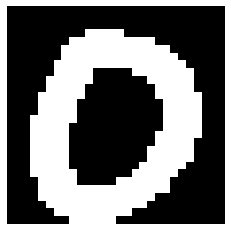

In [17]:
plt.imshow(X_train[0].reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()

In [18]:
print(Y_train[0])

0


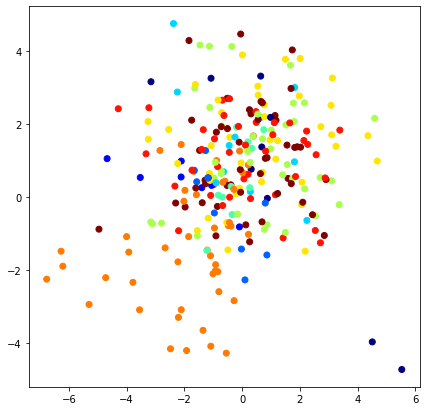

In [19]:
z_train = encoder.predict([X_train, y_train])
encodings= np.asarray(z_train)
encodings = encodings.reshape(X_train.shape[0], n_z)
plt.figure(figsize=(7, 7))
plt.scatter(encodings[:, 0], encodings[:, 1], c=Y_train, cmap=plt.cm.jet)
plt.show()

In [20]:
def construct_numvec(digit, z = None):
    out = np.zeros((1, n_z + n_y))
    out[:, digit + n_z] = 1.
    if z is None:
        return(out)
    else:
        for i in range(len(z)):
            out[:,i] = z[i]
        return(out)
    
sample_3 = construct_numvec(3)
print(sample_3)

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


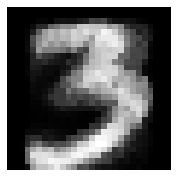

In [21]:
plt.figure(figsize=(3, 3))
plt.imshow(decoder.predict(sample_3).reshape(28,28), cmap = plt.cm.gray), axis('off')
plt.savefig('D:/srpdata/prepro_data1/g1.png', dpi=None, facecolor='w', edgecolor='w', orientation='portrait', papertype=None, format=None, transparent=False, bbox_inches='tight', pad_inches=0, frameon=None, metadata=None)
plt.show()

In [22]:
# out1 = decoder.predict(sample_3).reshape(28,28)
# print(out1)

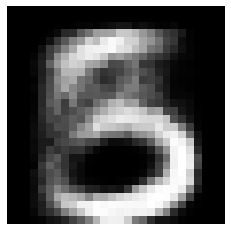

In [31]:
dig = 1
sides = 8
max_z = 1.5


for i in range(0, sides):
    z1 = (((i / (sides-1)) * max_z)*2) - max_z
    for j in range(0, sides):
        z2 = (((j / (sides-1)) * max_z)*2) - max_z
        z_ = [z1, z2]
        vec = construct_numvec(dig, z_)
        decoded = decoder.predict(vec)
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')
        outpath = 'D:/srpdata/g_new/new11/'+ str(i) + str(j) + '.png'
        plt.savefig(outpath, dpi=None, facecolor='w', edgecolor='w', orientation='portrait', papertype=None, format=None, transparent=False, bbox_inches='tight', pad_inches=0, frameon=None, metadata=None)


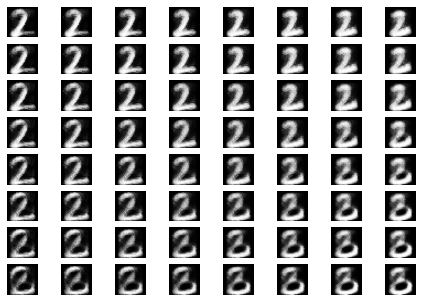

In [24]:
dig = 2
sides = 8
max_z = 1.5

img_it = 0
for i in range(0, sides):
    z1 = (((i / (sides-1)) * max_z)*2) - max_z
    for j in range(0, sides):
        z2 = (((j / (sides-1)) * max_z)*2) - max_z
        z_ = [z1, z2]
        vec = construct_numvec(dig, z_)
        decoded = decoder.predict(vec)
        subplot(sides, sides, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()